# Promotional Model for Forecasting

## Data Description

In this dataset you can find the below columns:
account_id, product_id, MAG, AG, date_id, promo_flag, promo_discount_perc, base_demand, ordered_units

In this sample there is only one account,

MAG:highest product hierarchy level 

AG:next highest prodct level

product id: SKU that the model should be able to predict the final order_units for it

So,  MAG-> AG -> product_id is the product hierarchy

date_id: an integer represents a day in a week,

promo_flag: indicates when a promotion was reported, 

promo_discount_perc: the promotion percentage calculated from the sales price,

base_demand: represents the product demand in the absence of any promotion, 

ordered_units: final forecast for the model to generate.

##### CODE (for Model Selection, by running Model Validation on 'base_promo_trainset.csv'):

In [431]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

In [432]:
# Importing the dataset
dataset = pd.read_csv('base_promo_trainset.csv')
# Rajeev: let us do a data preprocessing and see the observe the data before directly assigning test and train sets. 
#Hence commenting below
#X = dataset.iloc[:, 5:8].values
#y = dataset.iloc[:, 8].values

In [433]:
print(dataset.head(5))

   account_id  product_id  MAG   AG  date_id  promo_flag  promo_discount_perc  \
0           1           9  E01  638      738           0             0.000000   
1           1          10  E01  638      738           0             0.000000   
2           1          10  E01  638      745           0             0.000000   
3           1          10  E01  638      752           0             5.031578   
4           1          10  E01  638      759           0             3.331446   

   base_demand  ordered_units  
0         18.0             89  
1         97.0             97  
2        271.0            271  
3        120.0            120  
4         64.0             64  


In [434]:
print(dataset.describe())

# Rajeev: visualize the unique classes on each of variables.
print('\n Visualize the unique classes on each of variables')
print('MAG: '+str(np.unique(dataset['MAG'])))
print('AG: '+str(np.unique(dataset['AG'])))
print('product_id: '+str(np.unique(dataset['product_id'])))
print('account_id: '+str(np.unique(dataset['account_id'])))

       account_id    product_id            AG       date_id    promo_flag  \
count     15347.0  15347.000000  15347.000000  15347.000000  15347.000000   
mean          1.0   2846.052388   4151.085750   1119.672640      0.234313   
std           0.0   1678.818820   2602.233166    221.784145      0.423582   
min           1.0      9.000000    620.000000    738.000000      0.000000   
25%           1.0    609.000000   3010.000000    927.000000      0.000000   
50%           1.0   3739.000000   3157.000000   1123.000000      0.000000   
75%           1.0   3944.000000   7160.000000   1312.000000      0.000000   
max           1.0   5073.000000   8958.000000   1494.000000      1.000000   

       promo_discount_perc   base_demand  ordered_units  
count         15347.000000  15347.000000   15347.000000  
mean              4.884157    241.435670     303.245129  
std              10.138480    655.944153     916.858783  
min             -57.989063      0.000000   -1917.000000  
25%             

In [435]:
# Let us see how many unique products are there.
dataset['uniqueprod'] = dataset['MAG'].astype(str)+'_'+dataset['AG'].astype(str)+'_'+dataset['product_id'].astype(str)
print('Number of Unique products \n')
print(len(np.unique(dataset['uniqueprod'])))


Number of Unique products 

150


In [437]:
# Looking at the data set , it makes sense to use Time Series forcasting of 150 products over the time for 15k samples. 
# On an avarage 100 samples should be sufficient to build  Time Series forecasting model, that captures the demand well.

# Since I could not find sufficient time this week, I will tune the existing model to perform better.

# either we can build a decision tree(random forest, XGBOOST) based method. In the decision tree model 'date_id' doesnt make sense.

#print(dataset.isnull()) Rajeev: commented this line since in a long dataframe we cant actually see 
# which is True and which is False. Below line should print NaN values
print(dataset.isnull().values.any())

False


Since we can observe there are no missing values in the given dataset, we can skip using Imputer funtion to fill out the same.

In [438]:
# Taking care of missing data

#from sklearn.preprocessing import Imputer
#imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
#imputer = imputer.fit(X[:, 5:8])
#X[:, 5:8] = imputer.transform(X[:, 5:8])


In [439]:
#since the promo discount of -57% doesnt make sense and we clean the values less than zero. 
# I'm not sure what is actually negative discount means. Since we cant sell products more than MRP. Hence cleaning it
# Also the discount of 99.86% also doesnot make sense. In this case we see 99.5 and 0.005 percentile or 1.5 times IQR data 
#to be outliers. # Let us check these values.
print('\n Size of Existing Dataset: '+str(len(dataset)))
#dataset['promo_discount_perc']=np.where(dataset['promo_discount_perc']<=0,0,dataset['promo_discount_perc'])

print('\n Size of Existing Dataset after removing -negavtive discounts: '+str(len(dataset)))
dataset= dataset[dataset['promo_discount_perc']<dataset['promo_discount_perc'].quantile(0.995)]
dataset= dataset[dataset['promo_discount_perc']>dataset['promo_discount_perc'].quantile(0.005)]

print('\n Size of Existing Dataset after removing outlier discount % : '+str(len(dataset)))

# we can do these similar exercises to remove outliers on the other variables are well.



 Size of Existing Dataset: 15347

 Size of Existing Dataset after removing -negavtive discounts: 15347

 Size of Existing Dataset after removing outlier discount % : 15192


In [440]:

mag=list(pd.Series(dataset['uniqueprod']).unique())
for i in range(len(mag)):
    ttl=mag[i]
    ttl1=ttl+'1'
    dataset[ttl1] = dataset['uniqueprod'].str.contains(ttl)
    dataset[ttl1] = dataset[ttl1].map({True: 1, False: 0})

del dataset['MAG']
y= dataset['ordered_units']
del  dataset['ordered_units']
del dataset['account_id']
del dataset['date_id']
del dataset['uniqueprod'] 

print(dataset.head())

   product_id   AG  promo_flag  promo_discount_perc  base_demand  E01_638_91  \
0           9  638           0             0.000000         18.0           1   
1          10  638           0             0.000000         97.0           0   
2          10  638           0             0.000000        271.0           0   
3          10  638           0             5.031578        120.0           0   
4          10  638           0             3.331446         64.0           0   

   E01_638_101  E01_638_131  E01_638_261  E01_620_431  ...  E01_620_40161  \
0            0            0            0            0  ...              0   
1            1            0            0            0  ...              0   
2            1            0            0            0  ...              0   
3            1            0            0            0  ...              0   
4            1            0            0            0  ...              0   

   E01_620_40221  W91_3010_49121  W91_3010_49141  E01_62

In [441]:
# Splitting the data into the Training set and Test set from the training dataset file for model selection
X = dataset

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)



In [394]:
# Feature Scaling (Not required in Random Forest case)

#from sklearn.preprocessing import StandardScaler
#sc_X = StandardScaler()
#X_train = sc_X.fit_transform(X_train)
#X_test = sc_X.transform(X_test)
#sc_y = StandardScaler()
#y_train = sc_y.fit_transform(y_train.reshape(-1,1))


In [395]:
# Use the grid search cv to find the optimum parameters, this can be fine tuned with more effort.
# randomized search cv also can be used in case further tune the model but it is quite slow.
# set n_jobs=-1 for parallel run
rfr=RandomForestRegressor(random_state=1234,n_jobs=-1)

param_grid = { 
    'n_estimators': [5,10,25,35,40,50,60,75,90,100,120,150,170,190,200,220,250],
    'max_features': [0.4,0.45,0.5, 0.55,0.6, 0.65, 0.7,0.8, 0.9],
    'max_depth' : [6,7,8,9,10,11,12,13,14]
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 5,n_jobs=-1)
CV_rfr.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=1234,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'max_depth': [6, 7, 8, 9, 10, 11, 1

In [442]:
CV_rfr.best_params_

{'max_depth': 14, 'max_features': 0.7, 'n_estimators': 50}

In [443]:
# Fitting Decision Tree Regression to the dataset

#from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=50, max_depth=14,max_features= 0.7, random_state = 1234,n_jobs=-1)
#regressor_1 = RandomForestRegressor(n_estimators=10, random_state = 0)
#regressor = cross_val_score(regressor_1, X_train, y_train, cv =10)

regressor.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=14,
                      max_features=0.7, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
                      oob_score=False, random_state=1234, verbose=0,
                      warm_start=False)

In [444]:
#Predicting new results
y_pred = regressor.predict(X_test)

In [445]:
# Calculating r-squared using metrics class from sklearn

from sklearn import metrics
print(metrics.r2_score(y_test,y_pred))


0.9069360083770887


In [446]:
#print("RSquare: %0.2f (+/- %0.2f)" % (regressor.mean(), regressor.std() * 2))

In [447]:
#calculating average absolute error 
error = abs(y_pred - y_test)
print(error.mean())
print(error.std())


61.556951938812254
238.5522222733764


In [448]:
#Calculating the stats metrices having p value, r-squared and adjusted r-sqaurd values
import statsmodels.api as sm
X = np.append(arr = np.ones((len(dataset),1)).astype(int), values= X, axis = 1 )

X_opt = X[:, [0,1,2,3,4,5,6,7,8,9,10]]
regressor_OLS = sm.OLS(endog=y, exog=X_opt).fit()
print(regressor_OLS.summary())


                            OLS Regression Results                            
Dep. Variable:          ordered_units   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     4779.
Date:                Wed, 11 Dec 2019   Prob (F-statistic):               0.00
Time:                        07:40:41   Log-Likelihood:            -1.1340e+05
No. Observations:               15192   AIC:                         2.268e+05
Df Residuals:                   15181   BIC:                         2.269e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -29.4195      9.140     -3.219      0.0

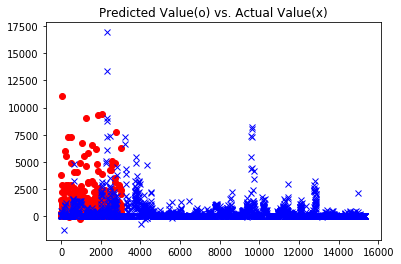

In [449]:
#plotting the actual and predicted value
plt.plot(y_pred, 'o', color = 'red')
plt.plot(y_test, 'x', color= 'blue')
plt.title('Predicted Value(o) vs. Actual Value(x)')
plt.show()

##### CODE (for Prediction on given Test dataset):

In [470]:
# Importing the dataset
# Rajeev; Using the data read earlier
dataset = pd.read_csv('base_promo_trainset.csv')

#X_train = dataset_train.iloc[:, 5:8].values
#y_train = dataset_train.iloc[:, 8].values

dataset_test = pd.read_csv('base_promo_testset.csv')


In [471]:
print(dataset_test.head(5))

   account_id  product_id  MAG   AG  date_id  promo_flag  promo_discount_perc  \
0           1          10  E01  638     1501           0             0.000000   
1           1          10  E01  638     1508           0             0.000000   
2           1          10  E01  638     1515           0             0.000000   
3           1          13  E01  638     1501           0             0.088674   
4           1          13  E01  638     1508           0             0.088674   

   base_demand  ordered_units  
0          0.0            NaN  
1          0.0            NaN  
2          0.0            NaN  
3          4.0            NaN  
4          0.0            NaN  


In [472]:
print(dataset_test.describe())

# Rajeev: visualize the unique classes on each of variables.
print('\n Visualize the unique classes on each of variables')
print('MAG: '+str(np.unique(dataset_test['MAG'])))
print('AG: '+str(np.unique(dataset_test['AG'])))
print('product_id: '+str(np.unique(dataset_test['product_id'])))
print('account_id: '+str(np.unique(dataset_test['account_id'])))

       account_id   product_id           AG      date_id  promo_flag  \
count       542.0   542.000000   542.000000   542.000000  542.000000   
mean          1.0  2836.822878  4175.957565  1510.673432    0.081181   
std           0.0  1702.934145  2630.693350     7.529510    0.273365   
min           1.0     9.000000   620.000000  1501.000000    0.000000   
25%           1.0   296.000000  3010.000000  1501.000000    0.000000   
50%           1.0  3745.000000  3157.000000  1508.000000    0.000000   
75%           1.0  3952.500000  7160.000000  1515.000000    0.000000   
max           1.0  5073.000000  8958.000000  1522.000000    1.000000   

       promo_discount_perc  base_demand  ordered_units  
count           542.000000   542.000000            0.0  
mean              2.892223   264.342979            NaN  
std               9.539602   843.806447            NaN  
min               0.000000     0.000000            NaN  
25%               0.000000     0.000000            NaN  
50%      

In [473]:
#print(dataset.isnull()) Rajeev: commented this line since in a long dataframe we cant actually see 
# which is True and which is False. Below line should print NaN values
print(dataset_test.isnull())

     account_id  product_id    MAG     AG  date_id  promo_flag  \
0         False       False  False  False    False       False   
1         False       False  False  False    False       False   
2         False       False  False  False    False       False   
3         False       False  False  False    False       False   
4         False       False  False  False    False       False   
5         False       False  False  False    False       False   
6         False       False  False  False    False       False   
7         False       False  False  False    False       False   
8         False       False  False  False    False       False   
9         False       False  False  False    False       False   
10        False       False  False  False    False       False   
11        False       False  False  False    False       False   
12        False       False  False  False    False       False   
13        False       False  False  False    False       False   
14        

In [474]:
# Let us see how many unique products are there.
dataset_test['uniqueprod'] = dataset_test['MAG'].astype(str)+'_'+dataset_test['AG'].astype(str)+'_'+dataset_test['product_id'].astype(str)
print('Number of Unique products \n')
print(len(np.unique(dataset_test['uniqueprod'])))

Number of Unique products 

148


In [475]:
dataset['uniqueprod'] = dataset['MAG'].astype(str)+'_'+dataset['AG'].astype(str)+'_'+dataset['product_id'].astype(str)
mag=list(pd.Series(dataset['uniqueprod']).unique())
for i in range(len(mag)):
    ttl=mag[i]
    ttl1=ttl+'1'
    dataset_test[ttl1] = dataset_test['uniqueprod'].str.contains(ttl)
    dataset_test[ttl1] = dataset_test[ttl1].map({True: 1, False: 0})

del dataset_test['MAG']
y= dataset_test['ordered_units']
del  dataset_test['ordered_units']
del dataset_test['account_id']
del dataset_test['date_id']
del dataset_test['uniqueprod'] 

print(dataset_test.head())

   product_id   AG  promo_flag  promo_discount_perc  base_demand  E01_638_91  \
0          10  638           0             0.000000          0.0           0   
1          10  638           0             0.000000          0.0           0   
2          10  638           0             0.000000          0.0           0   
3          13  638           0             0.088674          4.0           0   
4          13  638           0             0.088674          0.0           0   

   E01_638_101  E01_638_131  E01_638_261  E01_620_431  ...  E01_620_40161  \
0            1            0            0            0  ...              0   
1            1            0            0            0  ...              0   
2            1            0            0            0  ...              0   
3            0            1            0            0  ...              0   
4            0            1            0            0  ...              0   

   E01_620_40221  W91_3010_49121  W91_3010_49141  E01_62

In [481]:
# Fitting Decision Tree Regression to the dataset
# below was the regressor we have used earlier.
#regressor = RandomForestRegressor(n_estimators=50, max_depth=14,max_features= 0.7, random_state = 1234,n_jobs=-1)
X_test = dataset_test
print(len(y_test))
print(len(X_test))

3039
542


In [477]:
#Predicting a new result

y_pred = regressor.predict(X_test)
from sklearn import metrics
print(metrics.r2_score(y_test,y_pred))

#calculating average absolute error 
error = abs(y_pred - y_test)
print(error.mean())
print(error.std())



ValueError: Found input variables with inconsistent numbers of samples: [3039, 542]

In [22]:
#Calculating the OLS summary

#import statsmodels.api as sm
#X_train = np.append(arr = np.ones((15347,1)).astype(int), values= X_train, axis = 1 )
#X_opt = X_train[:, [0,1,2,3]]
#regressor_OLS = sm.OLS(endog=y_train, exog=X_opt).fit()
#print(regressor_OLS.summary())

In [23]:
# Rounding off the Predicted ordered units to nearest integer

y_round = [round(x) for x in y_pred]

In [27]:
# And finally writing the predicted ordered unit into the test dataset file

datafile = pd.read_csv('base_promo_testset.csv')
datafile['ordered_units'] = y_round
datafile.to_csv('base_promo_testset_pred.csv')